# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines** 
***
**Advanced Lane Finding Project**

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## 1. Camera Calibration

Determining the camera calibration matrix and distortion coefficients is the first step toward correcting distortion in images. To obtain these we use a set of chessboard images and OpenCV's `calibrateCamera()` and `findChessboardCorners()` functions. Chessboard corners are detected in each image using `findChessboardCorners()` and are stored in the `img_points` array. For each set of `img_points` found a corresponding set of 3D points representing the position of the corner in the world coordinate space is kept in `obj_points`. These `obj_points` and `img_points` are then fed to `calibrateCamera()` to obtain our calibration matrix and distortion coefficients. Given an image, the matrix, and the distortion coefficients, OpenCV's `undistort()` can then be used to correct for distortion on any image taken with that camera and lens.

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import project_data
import camera
%matplotlib inline

Calibrating...
Done


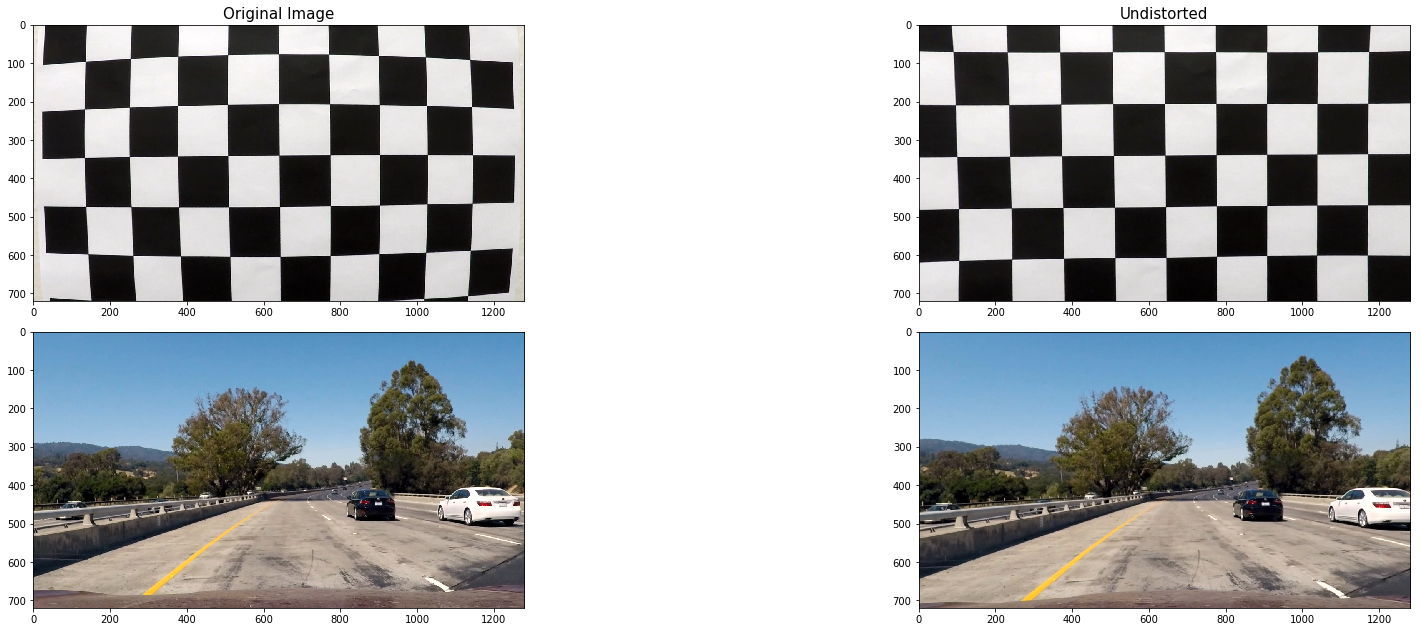

In [2]:
#
# Read in images
# calibration1.jpg is a chessboard. test3.jpg is an
# image of a road.  
img1 = cv2.imread('camera_cal/calibration1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('test_images/test1.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

#
# calibrate() function is in camera.py
#
print('Calibrating...')
mtx, dist = camera.calibrate()
print('Done')

#
# Using the matrix and coefficents, undistort the images. 
#
undist1 = cv2.undistort(img1, mtx, dist, None, mtx)
undist = cv2.undistort(img2, mtx, dist, None, mtx)

#
# Display images.
#
f, axes = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
axes[0, 0].imshow(img1)
axes[0, 0].set_title('Original Image', fontsize=15)
axes[0, 1].imshow(undist1)
axes[0, 1].set_title('Undistorted', fontsize=15)
axes[1, 0].imshow(img2)
axes[1, 1].imshow(undist)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


---

## 2. Thresholding

The next step after distortion correction is thresholding.  Finding the correct thresholding to handle all different colors, shadows, reflections, and other noise was a tricky problem. To reduce noise in the image I initially perform a gaussian blur.  

The color spaces I eventually settled on are the L Channel of the LUV color space for picking up white lines and the B Channel of the Lab color space for picking up yellow lines.  I used different threshold values for each video but I found that for the `project_video.mp4` L values between 199 and 255 and B values between 159 and 255 worked fairly well in the general case.  Shadows in the challenge videos were a particularly difficult problem and I attempted to do an adaptive threshold where sections of the image with lower brightness could be thresholded with different values but I only saw modest gains.  I finally settled on breaking the image up into 9 sections in the Y dimension and 20 sections in the X dimension. Lower brightness values for `project_video.mp4` were between 118 and 255 for the L channel and 159 and 255 for the B Channel.   All project thresholding values can be found in `project_data.py`



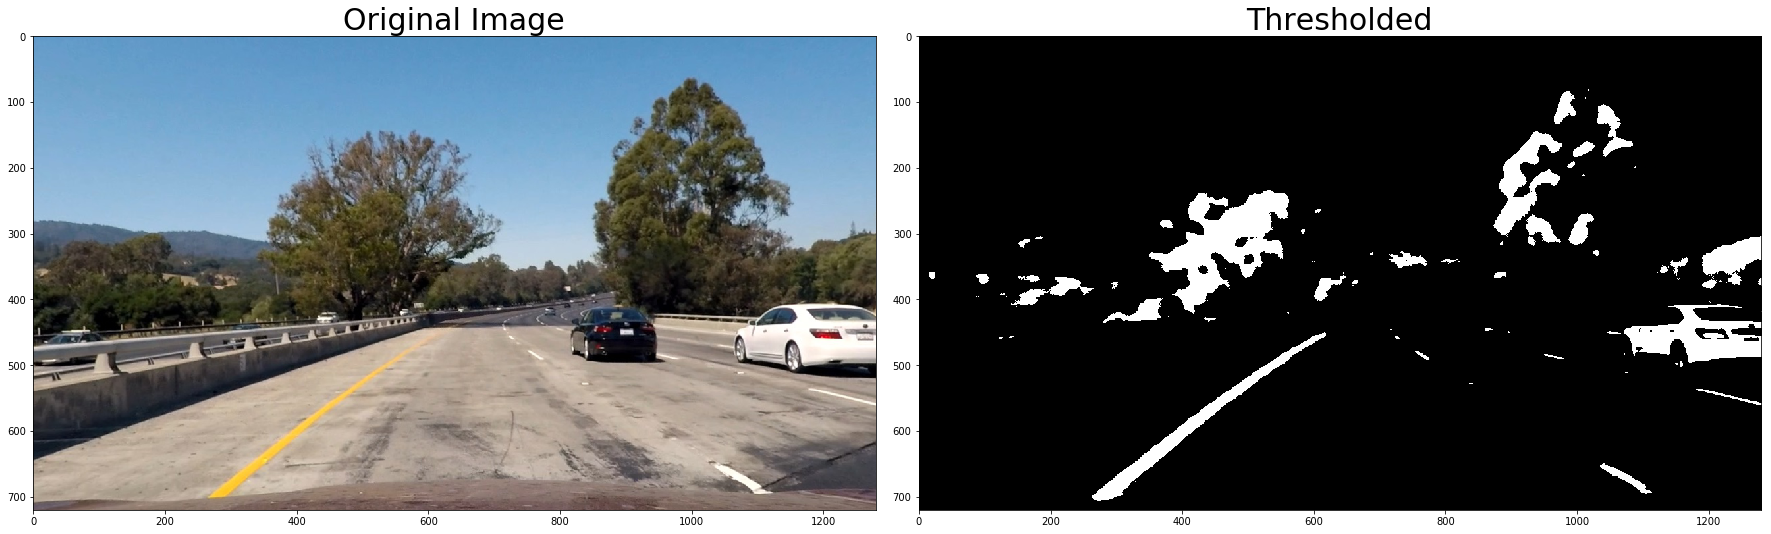

In [3]:
import image_utils

l_threshold = np.array([(213, 255), (203, 255)])
b_threshold = np.array([(145, 255), (196, 255)])
thresholded = image_utils.threshold_image(undist, l_threshold, b_threshold, 0)

f, axes = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
axes[0].imshow(undist)
axes[0].set_title('Original Image', fontsize=30)
axes[1].imshow(thresholded, cmap='gray')
axes[1].set_title('Thresholded', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()




---

## 3. Transforming an image


The next step is to warp the image into a bird's-eye view.  The perspective matrix for performing this transformation is obtained by a call to the openCV function `getPerspectiveTransform()`.  To calculate this `getPerspectiveTransform()` needs points from the source image mapped to locations in the destination image.  In an attempt to handle differing image sizes I kept source points normalized between 0 and 1.  Four source points were mapped to destination points in the following manner:

- (bottom_left_x, bottom_left_y) in the source mapped to (bottom_right_x, height_of_image) in the destination
- (top_left_x, top_left_y) in the source mapped to (bottom_left_x, 0) in the destination
- (top_right_x, top_right_y) in the source mapped to (bottom_right_x, 0) in the destination
- (bottom_right_x, bottom_right_y) in the source mapped to (bottom_right_x, height_of_image) in the destination


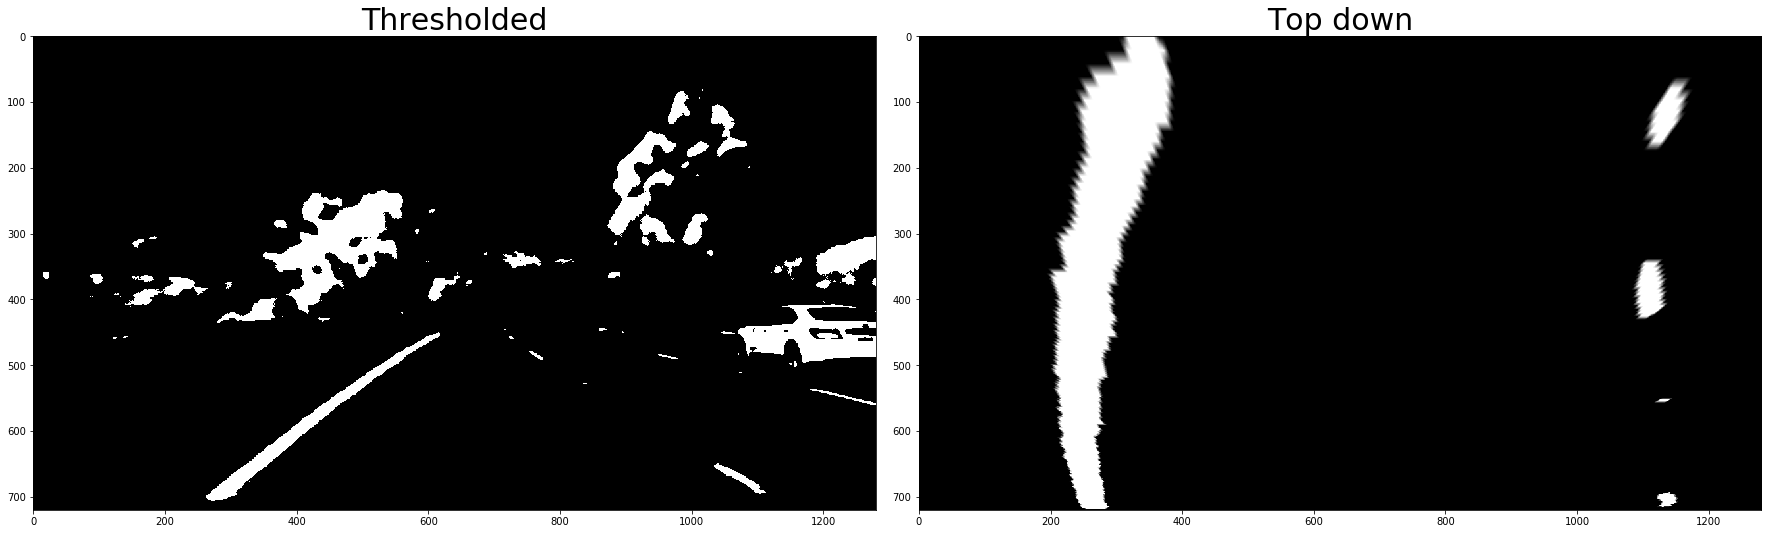

In [4]:
src_points = np.float32([(221, 710), (600, 451), (721, 451), (1177, 710)])
dst_points = np.float32([(221, 720), (221,  0), (1177, 0), (1177, 720)])
                       
warped = image_utils.warp_image(thresholded, src_points, dst_points)

f, axes = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
axes[0].imshow(thresholded, cmap='gray')
axes[0].set_title('Thresholded', fontsize=30)
axes[1].imshow(warped, cmap='gray')
axes[1].set_title("Top down", fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()



Once the proper source and destintion points are mapped all it takes is a call to `cv2.warpPerspective()` to take the image to/from a top-down view.  The function `warp_image()` in the file `image_utils.py` (lines 58-71) takes care of both obtaining the perspective matrix and warping the image.

---
## 4. Recognizing lanes





The bulk of the work to recognize the lane lines is done in the function `find_lane_lines().`
This function takes one of two approaches to finding the lane lines:

If this is the first detection or the previous line was not been successfully detected:
- Take a histogram of the bottom half of the warped and thresholded binary image.
- Take the histogram peak on each half of the image as the starting point of each line.
- Using a 'sliding window approach' move upwards in the image adjusting the window position as necessary to follow the area with the largest number of pixels.
- use Numpy's `polyfit()` to fit the pixels to a polynomial.

OR:
If a previous line has been successfully detected and mapped to a polynomial:
- Since the lane lines do not move much from frame to frame, use the previous frame's polynomial to search around for pixels in the current frame.

#### Line Class

To facilitate the holding of individual line data and properties I created a Line class.  The class implementation is in the file `p2.py` from line 80 to line 142.  This class holds the pixels detected, the line coefficients obtained from `polyfit()`, the line curvature, and derivatives taken at 3 points along the line.  A method is also provided to detect if the line is valid.


#### Line Validation

Several properties of the line are checked for validation of the line. The `isValid()` function of the `Line` class handles this determination.  Line slopes, coefficients, the number of pixels detected, and curvature factor into validation.


A visualization of the process can be seen in the lower right quadrant of this video frame: 
![Visualization](writeup_images/visualization.png)

## Line class

In [5]:
METERS_PER_PIXEL_X = 3.7/700
METERS_PER_PIXEL_Y = 30/720

#
# Lane line polynomial coefficients are averaged
# over X frames
#
AVERAGE_OVER_X_FRAMES = 7

#
# Lines with less pixel will be invalidated
#
MIN_PIXELS_FOR_VALID_LINE = 3000

#
# A change of slope of this amount over the polynomial
# will invalidate the line
#
SLOPE_TOLERANCE = 1.2


class Line:
    def __init__(self, x_pixels, y_pixels, height, detected = False):
        self.fitx = []
        self.fity = []
        self.lane_pixels_x = x_pixels
        self.lane_pixels_y = y_pixels
        self.detected = detected

        if len(self.lane_pixels_y) > 0 and len(self.lane_pixels_x) > 0:
            #
            # fit a polynomial using numpy polyfit
            #
            self.line_coefficients = np.polyfit(self.lane_pixels_y, self.lane_pixels_x, 2)

            #
            # Generate values for plotting
            #
            self.fity = np.linspace(0, height-1, height)
            self.fitx = (self.line_coefficients[0] * self.fity ** 2) + (self.line_coefficients[1] * self.fity) + self.line_coefficients[2]

            #
            # convert our line coordinates from pixel space to world space.
            #
            fity = self.fity * METERS_PER_PIXEL_Y
            fitx = self.fitx * METERS_PER_PIXEL_X

            #
            # Get the maximum y value to calculate the radius of curvature.
            #
            maxy = np.max(fity)

            #
            # fit to the new world space coordinates and calculate curvature
            #
            world_poly = np.polyfit(fity, fitx, 2)
            self.curvature = ((1 + ((2 * world_poly[0] * maxy) + world_poly[1]) ** 2) ** float(3/2)) / abs(2 * world_poly[0])

            self.upper_slope = (2 * self.line_coefficients[0] * self.fity[0]) + self.line_coefficients[1]
            self.mid_slope = (2 * self.line_coefficients[0] * self.fity[height//2]) + self.line_coefficients[1]
            self.lower_slope = (2 * self.line_coefficients[0] * self.fity[height-1]) + self.line_coefficients[1]
        else:
            self.detected = False

    def isValid(self):
        return (self.detected == True and
                (len(self.line_coefficients) == 3) and
                (len(self.lane_pixels_x) > MIN_PIXELS_FOR_VALID_LINE) and
                (abs(self.upper_slope - self.lower_slope) < 1.2) and
                (abs(self.upper_slope < SLOPE_TOLERANCE)) and
                (abs(self.mid_slope < SLOPE_TOLERANCE)) and
                (abs(self.lower_slope < SLOPE_TOLERANCE)))


    '''
    # Used to get the lowest point of the lane line, closest to the car,
    # when measuring the offset of the center of the car to the center of
    # the lane.
    # The maximum y value is used in the
    # polynomial to calculate the x value at the bottom of the screen
    '''
    def getLowestLinePoint(self):
        y = np.max(self.fity)
        return (self.line_coefficients[0] * y ** 2) + (self.line_coefficients[1] * y) + self.line_coefficients[2]


---
## 5. Measuring curvature and offset.

#### Curvature

To measure curvature I used the following formula

![image](writeup_images/equation.gif)

A Pixel space to world space conversion was made using standard lane widths and a polynomial was refit to the new world space values.  The curvature equation was then evaluated at the lowest point of the line(bottom of screen).

#### Offset

Offset was calculated under the assumption that the camera was recording from the center point of the car.  The difference of the center of the image from the center point between the detected lane lines was calculated and converted from pixel space to world space.



## 6. Render over image

The final step is the fill the lane area detected and render it back over the original image.  This is done by the function `fillLane()`( file `p2.py`, lines 304 through 341). 

OpenCV's `fillpoly()` was used to fill the lane boundaries and `warp_image()` was used in reverse to warp the image back into a first-person perspective.  

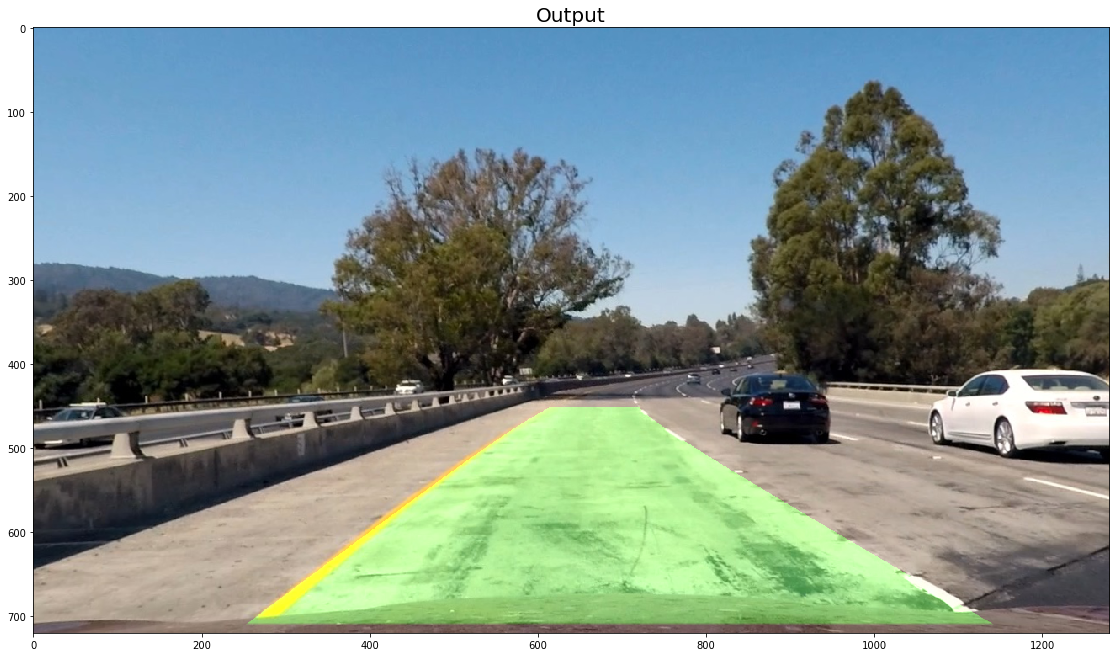

In [6]:
def find_lane_lines(binary_warped, left_line, right_line):
    height, width = binary_warped.shape

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds  = []
    right_lane_inds = []

    nwindows      = 9   # Choose the number of sliding windows
    window_margin = 75  # the width of the windows +/- margin
    poly_margin   = 50  # the margin when searching around poly
    minpix        = 75  # minimum number of pixels found to recenter window

    if (left_line is None or not left_line.isValid()) or (right_line is None or not right_line.isValid()):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[height//2:,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint       = np.int(histogram.shape[0]//2)
        leftx_base     = np.argmax(histogram[:midpoint])
        rightx_base    = np.argmax(histogram[midpoint:]) + midpoint
        leftx_current  = leftx_base
        rightx_current = rightx_base

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(height // nwindows)

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = height - (window+1) * window_height
            win_y_high = height - window * window_height

            ### Find the four below boundaries of the window ###
            win_xleft_low = leftx_current - window_margin
            win_xleft_high = leftx_current + window_margin
            win_xright_low = rightx_current - window_margin
            win_xright_high = rightx_current + window_margin

            ###  Identify the nonzero pixels in x and y within the window ###
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if (len(good_left_inds) >= minpix):
                avg_index = np.int(np.mean(nonzerox[good_left_inds]))
                leftx_current = avg_index

            if (len(good_right_inds) >= minpix):
                avg_index = np.int(np.mean(nonzerox[good_right_inds]))
                rightx_current = avg_index

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    else:
        #
        # We have valid lines from a previous frame.  We can search around the
        # polynomial for line pixels.
        #
        left_poly = left_line.line_coefficients
        right_poly = right_line.line_coefficients
        left_lane_inds = ((nonzerox > (left_poly[0]*(nonzeroy**2) + left_poly[1]*nonzeroy + left_poly[2] - poly_margin)) &
                          (nonzerox < (left_poly[0]*(nonzeroy**2) + left_poly[1]*nonzeroy + left_poly[2] + poly_margin)))
        right_lane_inds = ((nonzerox > (right_poly[0]*(nonzeroy**2) + right_poly[1]*nonzeroy + right_poly[2] - poly_margin)) &
                           (nonzerox < (right_poly[0]*(nonzeroy**2) + right_poly[1]*nonzeroy + right_poly[2] + poly_margin)))


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]


    # Our new lines.
    new_left_line = Line(leftx, lefty, height, True)
    new_right_line = Line(rightx, righty, height, True)

    left_fitx = new_left_line.fitx
    right_fitx = new_right_line.fitx
    ploty = np.linspace(0, height-1, height)

    #
    # validate lines.  Make sure they don't cross each other.
    #
    if new_left_line.isValid() and new_right_line.isValid() and np.min(np.absolute(right_fitx - left_fitx)) < 300:
        new_left_line.detected = False
        new_right_line.detected = False

    return new_left_line, new_right_line



def fillLane(avg_left, avg_right, src_points, dst_points, undist, warped):

    #
    # find our pixels to shade
    #
    height, width = undist.shape[:2]
    fity = np.linspace(0, height-1, height)
    left_fitx = (avg_left[0] * fity ** 2) + (avg_left[1] * fity) + avg_left[2]
    right_fitx = (avg_right[0] * fity ** 2) + (avg_right[1] * fity) + avg_right[2]

    #
    # transpose and prepare for fillpoly
    #
    left_transpose = np.transpose(np.vstack([left_fitx, fity]))
    right_transpose = np.transpose(np.vstack([right_fitx, fity]))

    left_pts = np.array([left_transpose])
    right_pts = np.array([np.flipud(right_transpose)])
    points =  np.hstack((left_pts, right_pts))

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    #
    # Draw the lane onto the warped blank image
    #
    cv2.fillPoly(color_warp, np.int_([points]), (0, 255, 0))

    #
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    #
    newwarp = image_utils.warp_image(color_warp, dst_points, src_points)

    #
    # Combine the result with the original image
    #
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result




left_line, right_line = find_lane_lines(warped, None, None)
out_img = fillLane(left_line.line_coefficients, right_line.line_coefficients, src_points, dst_points, undist, warped)

rgb = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
cv2.imwrite('foobar.jpg', rgb)

f, axes = plt.subplots(1, 1, figsize=(24, 9))
f.tight_layout()
axes.imshow(out_img)
axes.set_title('Output', fontsize=20)
plt.show()




---
# Videos

Both the project_video and the challenge_video went well. The harder_challenge_video exposed many weaknesses in my approach. The many shadows and bright spots on the road confused my algorithm, as did the bright grass off the right shoulder of the road. Even so, the lane detection does recover up until the last very brightly lit hairpin turn at the end.

Videos have been saved to the `./video_outputs` folder and can be loaded below.  

To run the code locally: 

`python p2.py <video-name>`

The video will be output with the filename `myvideo.mp4`



In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./video_outputs/project_video.mp4'))

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./video_outputs/challenge_video.mp4'))

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./video_outputs/harder_challenge_video.mp4'))